In [2]:
import numpy as np
import pandas as pd
import os
from PIL import Image, ImageDraw, ImageFont, ImageOps
import matplotlib.pyplot as plt
import seaborn as sns
import re
from shutil import copy2
import cv2

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.preprocessing import image as k_image
from tensorflow.keras.callbacks import ModelCheckpoint
import pocketsphinx

Total data gambar: 13440
Shape setiap gambar: (224, 224)


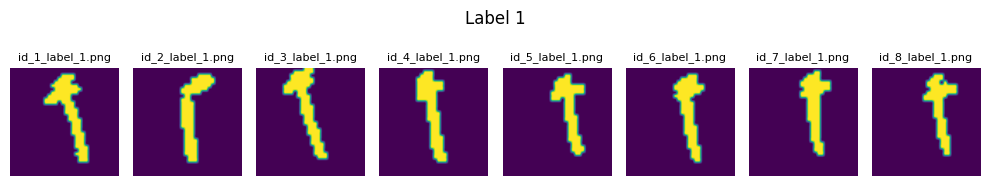

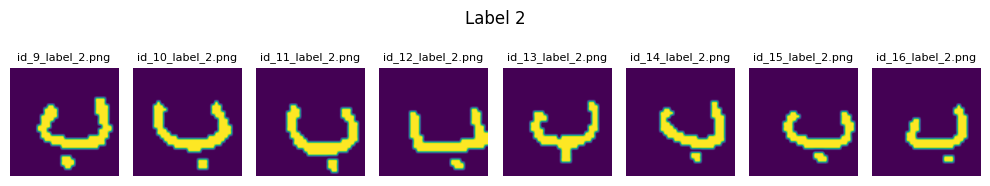

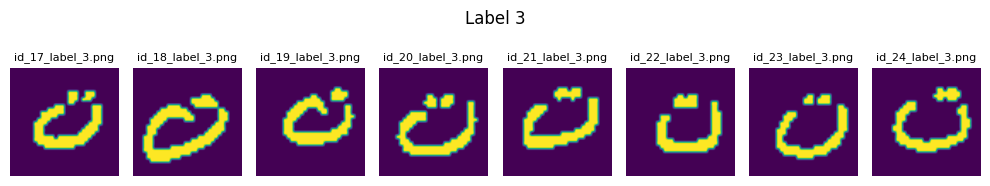

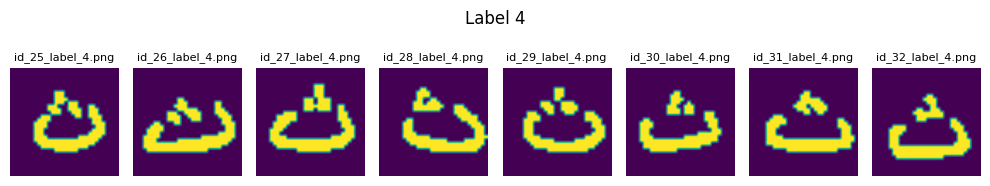

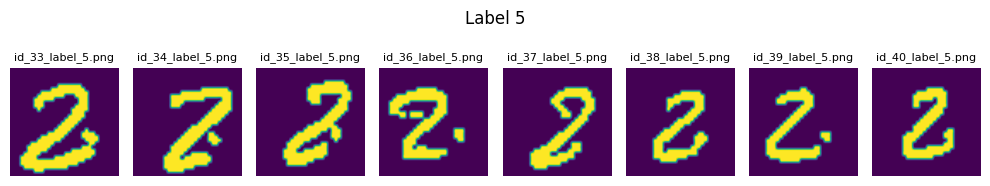

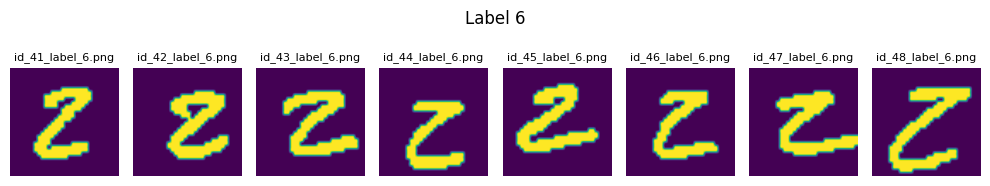

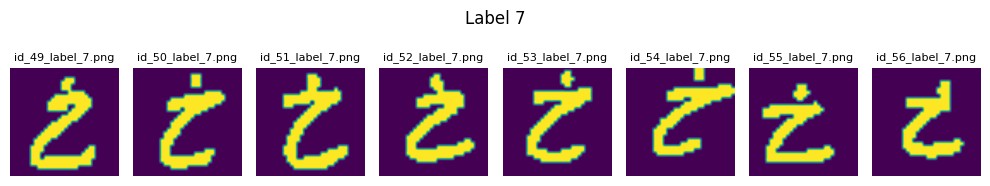

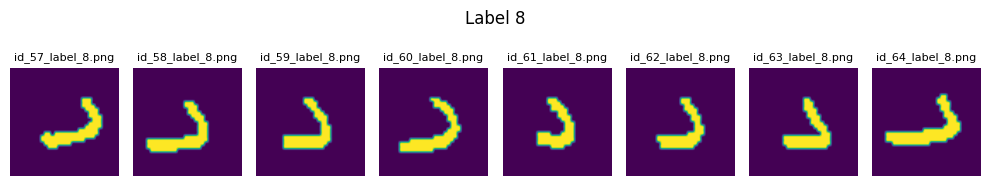

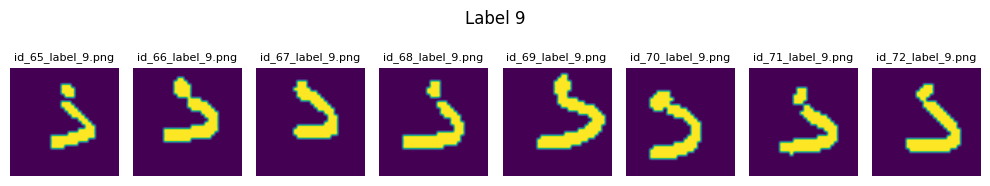

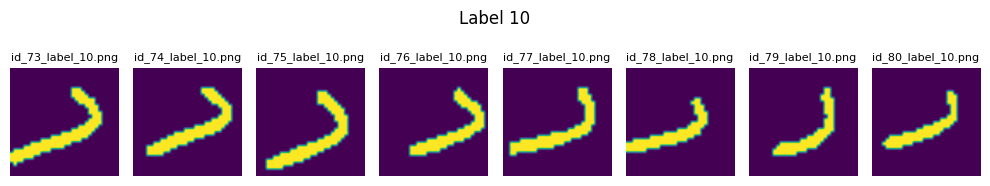

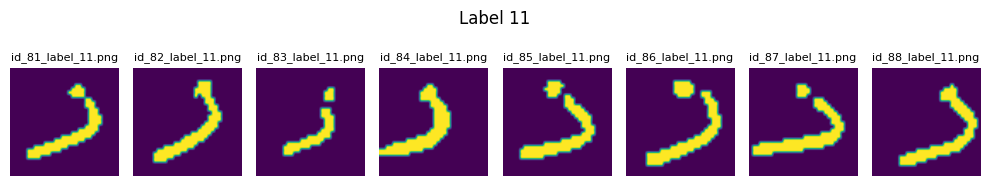

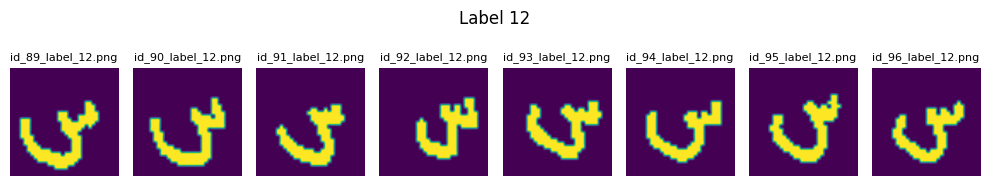

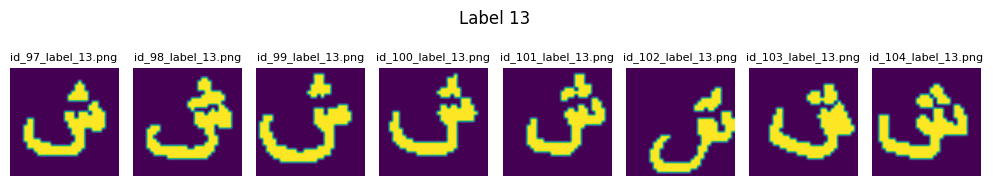

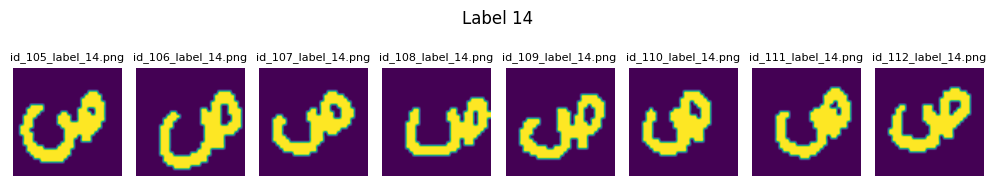

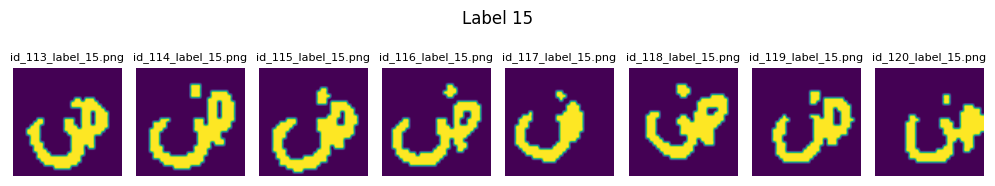

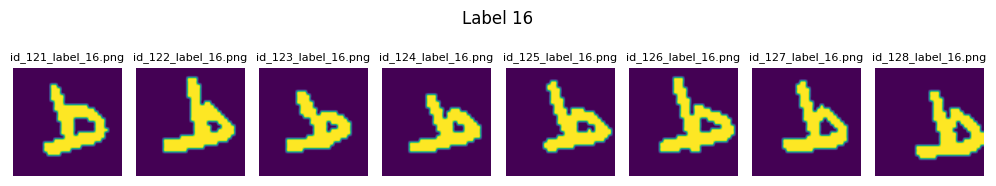

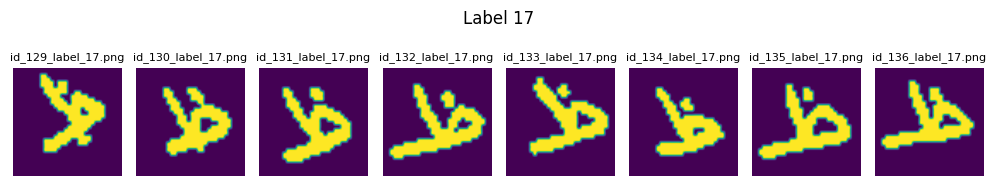

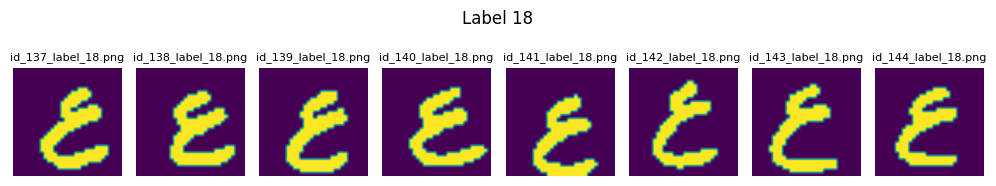

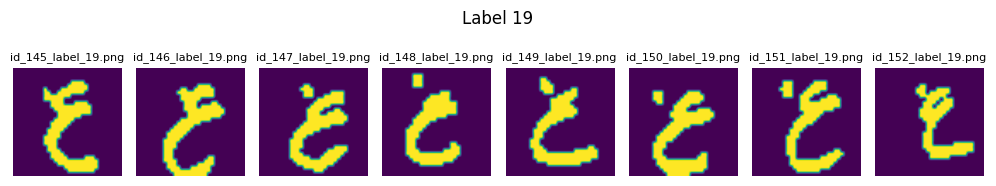

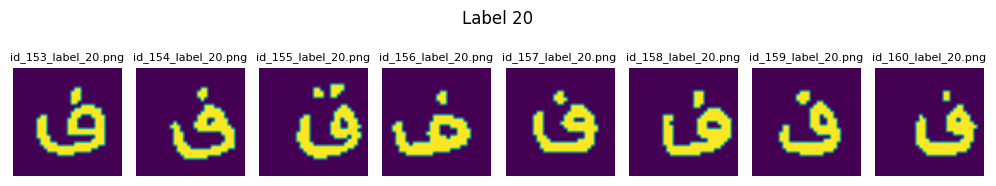

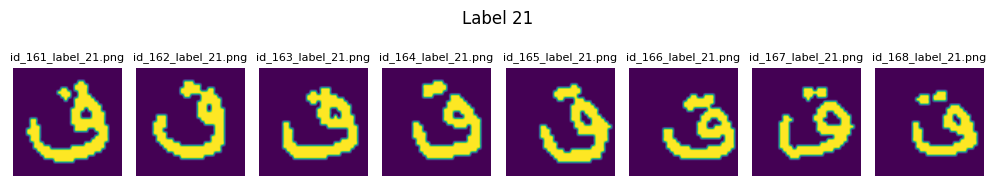

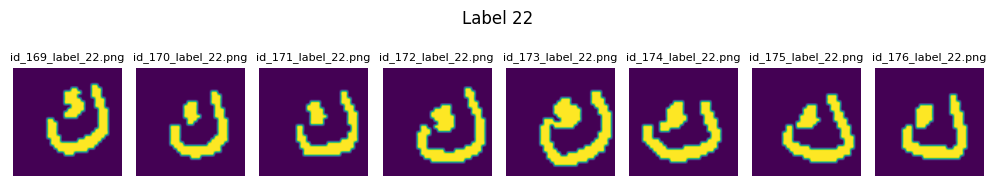

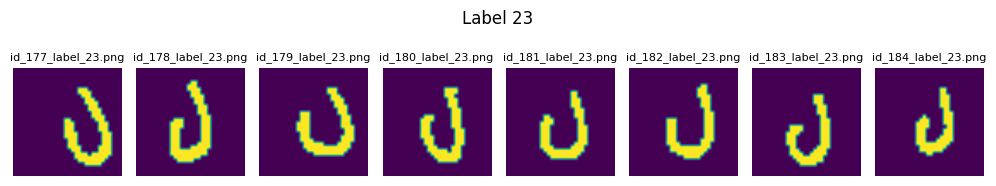

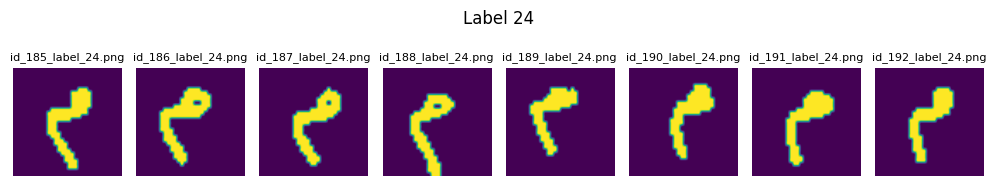

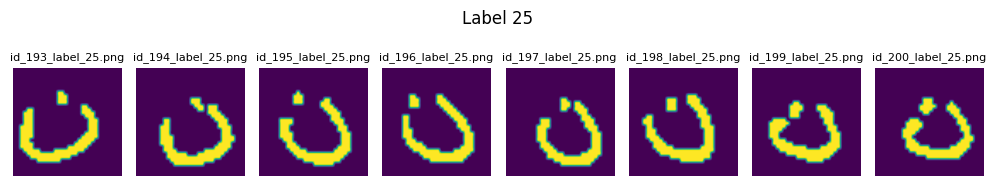

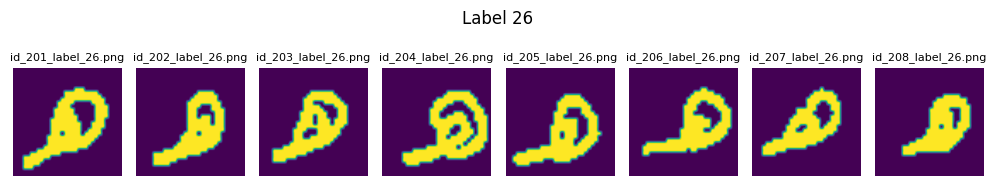

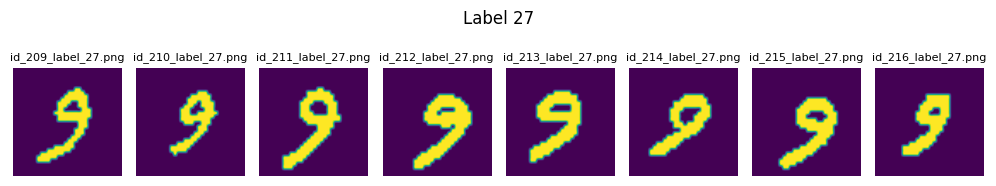

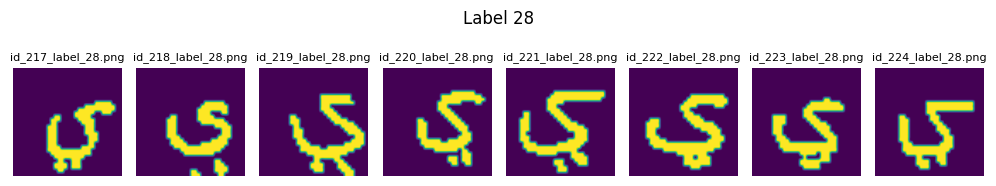

In [4]:
source_folder = r"C:\Users\gagah\Desktop\KKN\data\Train Images 13440x32x32\train"
size = 224

images_with_filenames = []

def extract_id(filename):
    match = re.search(r'id_(\d+)_', filename)
    return int(match.group(1)) if match else -1

file_list = [f for f in os.listdir(source_folder) if f.endswith(".png")]
file_list.sort(key=extract_id)

for filename in file_list:
    img_path = os.path.join(source_folder, filename)
    img = Image.open(img_path) 
    #img = ImageOps.invert(img)#.convert('L')
    img = img.resize((size, size))
    img_array = np.array(img)
    images_with_filenames.append((img_array, filename))

images = np.array([img[0] for img in images_with_filenames])
filenames = [img[1] for img in images_with_filenames]

print(f'Total data gambar: {len(images)}')
print(f'Shape setiap gambar: {images[0].shape}')


# Memunculkan gambar
# Memisahkan gambar berdasarkan label
label_dict = {}
for img_array, filename in images_with_filenames:
    match = re.search(r'label_(\d+)', filename)
    if match:
        label = int(match.group(1))
        if label not in label_dict:
            label_dict[label] = []
        label_dict[label].append((img_array, filename))

# Menampilkan gambar per label
for label, images in label_dict.items():
    fig, axes = plt.subplots(1, 8, figsize=(10, 2))
    axes = axes.ravel()
    for i in range(min(8, len(images))):
        axes[i].imshow(images[i][0])
        axes[i].axis('off')
        axes[i].set_title(images[i][1], fontsize=8)
    plt.suptitle(f'Label {label}')
    plt.tight_layout()
    plt.show()

In [ ]:
destination_folder = r"C:\Users\gagah\Desktop\KKN\data\Data_Train_Images"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)
file_list = [f for f in os.listdir(source_folder) if f.endswith(".png")]

for filename in file_list:
    match = re.search(r'id_(\d+)_label_(\d+)', filename)
    if match:
        img_id = match.group(1)
        label = match.group(2)
        
        # Membuat path folder label
        label_folder = os.path.join(destination_folder, f'lab_{label}')
        if not os.path.exists(label_folder):
            os.makedirs(label_folder)
        
        # Memuat dan menginversi gambar
        src_path = os.path.join(source_folder, filename)
        img = Image.open(src_path)
        img = ImageOps.invert(img)
        
        # Menyimpan gambar yang telah diubah ke folder tujuan dengan nama file baru
        dest_path = os.path.join(label_folder, f'id_{img_id}.png')
        img.save(dest_path)

In [5]:
def adjust_text_color(image):    
    # Jika tidak, ubah warna tulisan
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hue_shift = np.random.uniform(-10, 10)
    saturation_shift = np.random.uniform(0.5, 1.5)
    value_shift = np.random.uniform(0.5, 1.5)
    hsv_image[..., 0] = (hsv_image[..., 0] + hue_shift) % 180
    hsv_image[..., 1] = np.clip(hsv_image[..., 1] * saturation_shift, 0, 255)
    hsv_image[..., 2] = np.clip(hsv_image[..., 2] * value_shift, 0, 255)
    adjusted_image = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2BGR)
    return adjusted_image

def adjust_brightness_contrast(image):
    brightness = np.random.uniform(0.5, 1.5)
    contrast = np.random.uniform(0.5, 1.5)
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast, beta=brightness)
    return adjusted_image

def generate_random_background(image_shape):
    background_color = np.random.randint(0, 256, size=3).tolist()
    background = np.full((image_shape[0], image_shape[1], 3), background_color, dtype=np.uint8)
    return background

def apply_background_color(image):
    retain_black_prob = 0.65
    if np.random.rand() < retain_black_prob:
        return image
    background = generate_random_background(image.shape)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_image, 1, 255, cv2.THRESH_BINARY)
    binary_mask_3ch = cv2.cvtColor(binary_mask, cv2.COLOR_GRAY2BGR)
    combined_image = np.where(binary_mask_3ch == 255, image, background)
    return combined_image

def augment_image(image):
    image = adjust_text_color(image)
    image = adjust_brightness_contrast(image)
    image = apply_background_color(image)
    return image

# Create custom image generator
def custom_image_generator(directory, target_size, batch_size, color_mode='rgb'):
    datagen = ImageDataGenerator(
        preprocessing_function=lambda x: augment_image(k_image.img_to_array(x))
    )
    generator = datagen.flow_from_directory(
        directory=directory,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        color_mode=color_mode
    )
    return generator

# Set directories and parameters
TRAINING_DIR = "data/Data_Train_Images"

model_dir = 'model'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Define callbacks
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.90 and logs.get('val_accuracy') > 0.90:
            print("\nReached 90% accuracy so cancelling training!")
            print(f"accuracy : {logs.get('accuracy') * 100:.2f}% \n"
                  f"val_acc : {logs.get('val_accuracy') * 100:.2f}% \n")
            self.model.stop_training = True

checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(model_dir, 'model_{epoch:02d}_{val_accuracy:.2f}.h5'),
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# Create data generators
train_generator = custom_image_generator(
    directory=TRAINING_DIR,
    target_size=(size, size),
    batch_size=32,
    color_mode='rgb'
)

validation_generator = custom_image_generator(
    directory=TRAINING_DIR,
    target_size=(size, size),
    batch_size=32,
    color_mode='rgb'
)

Found 13440 images belonging to 28 classes.
Found 13440 images belonging to 28 classes.


In [21]:
lab_mapping = {}
with open('label_mapping.txt', 'r') as file:
    for line in file:
        if ':' in line:
            key, value = line.split(':')
            lab_mapping[int(key.strip())] = value.strip().strip("'").replace("'", "").replace(",", "")

for images, labels in train_generator:
    plt.figure(figsize=(8, 4))
    for i in range(8):
        plt.subplot(2, 4, i+1)
        img = np.clip(images[i], 0, 255).astype(np.uint8)  # Normalisasi dan konversi tipe data
        plt.imshow(img)
        plt.title(f'Label {lab_mapping[labels[i].argmax()]}')
        plt.axis('off')
    plt.show()
    break

ValueError: invalid literal for int() with base 10: "'lab_1'"

In [81]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(size, size, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(label_dict.keys()), activation='softmax'),
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# Train the model
model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint_callback, myCallback()]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)        0

c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


420/420 [==============================] - ETA: 0s - loss: 1.3750 - accuracy: 0.5766
Epoch 2: val_accuracy improved from 0.46674 to 0.68504, saving model to model\model_02_0.69.h5
420/420 [==============================] - 350s 832ms/step - loss: 1.3750 - accuracy: 0.5766 - val_loss: 0.9888 - val_accuracy: 0.6850
Epoch 3/100
420/420 [==============================] - ETA: 0s - loss: 0.8828 - accuracy: 0.7201
Epoch 3: val_accuracy improved from 0.68504 to 0.81042, saving model to model\model_03_0.81.h5
420/420 [==============================] - 336s 799ms/step - loss: 0.8828 - accuracy: 0.7201 - val_loss: 0.6080 - val_accuracy: 0.8104
Epoch 4/100
420/420 [==============================] - ETA: 0s - loss: 0.6099 - accuracy: 0.8050
Epoch 4: val_accuracy improved from 0.81042 to 0.86830, saving model to model\model_04_0.87.h5
420/420 [==============================] - 334s 796ms/step - loss: 0.6099 - accuracy: 0.8050 - val_loss: 0.4027 - val_accuracy: 0.8683
Epoch 5/100
420/420 [==========

In [18]:
model = load_model('model/model_07_0.93.h5')
model

TypeError: call() missing 1 required positional argument: 'inputs'

421/421 [==============================] - 93s 218ms/step


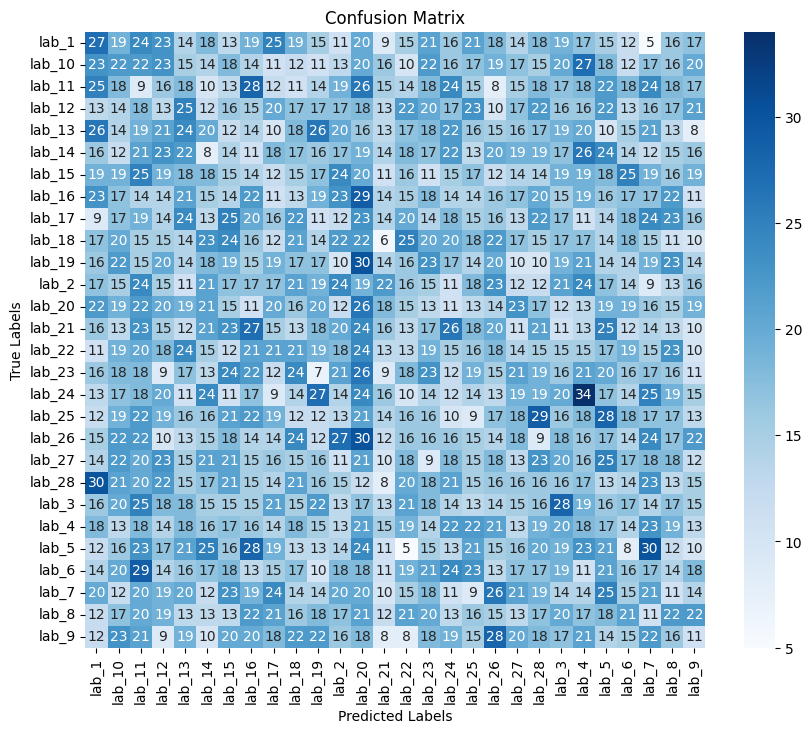

              precision    recall  f1-score   support

       lab_1       0.06      0.06      0.06       480
      lab_10       0.04      0.05      0.04       480
      lab_11       0.02      0.02      0.02       480
      lab_12       0.03      0.03      0.03       480
      lab_13       0.05      0.05      0.05       480
      lab_14       0.02      0.02      0.02       480
      lab_15       0.03      0.03      0.03       480
      lab_16       0.04      0.05      0.04       480
      lab_17       0.04      0.03      0.03       480
      lab_18       0.04      0.04      0.04       480
      lab_19       0.04      0.04      0.04       480
       lab_2       0.05      0.05      0.05       480
      lab_20       0.04      0.05      0.05       480
      lab_21       0.04      0.03      0.04       480
      lab_22       0.03      0.03      0.03       480
      lab_23       0.05      0.05      0.05       480
      lab_24       0.03      0.03      0.03       480
      lab_25       0.02    

In [11]:

# Generate predictions on the validation set
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

420/420 [==============================] - 84s 199ms/step


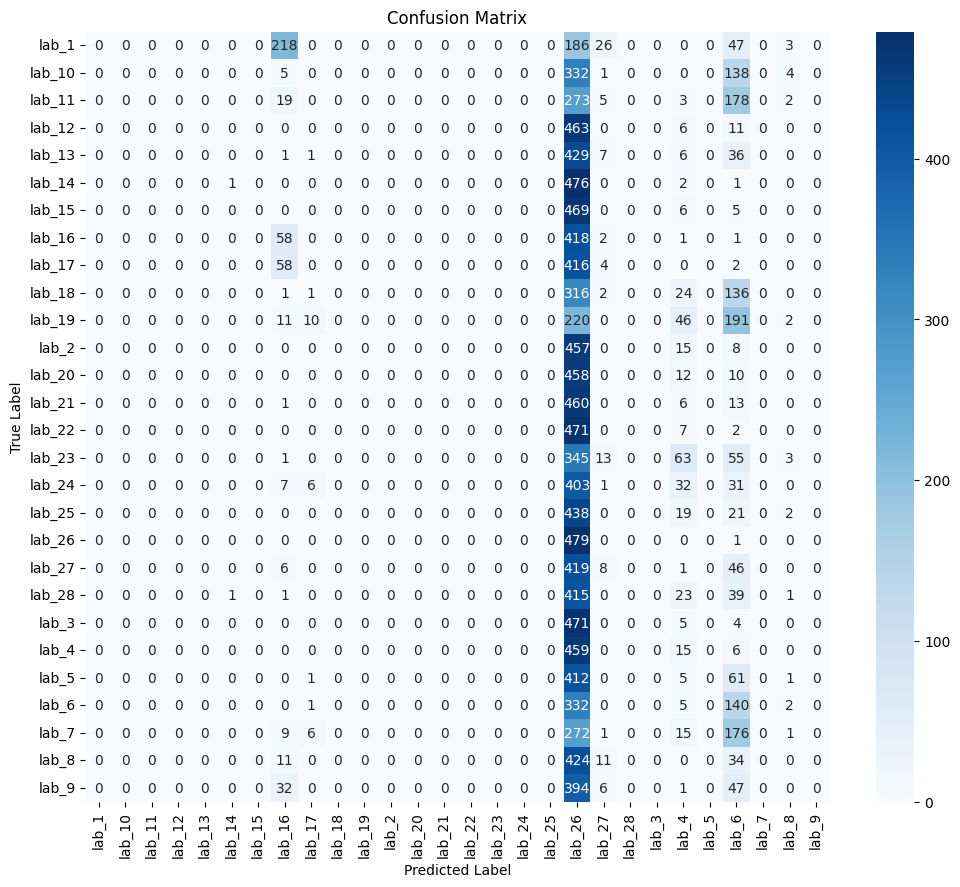

              precision    recall  f1-score   support

       lab_1       0.00      0.00      0.00       480
      lab_10       0.00      0.00      0.00       480
      lab_11       0.00      0.00      0.00       480
      lab_12       0.00      0.00      0.00       480
      lab_13       0.00      0.00      0.00       480
      lab_14       0.50      0.00      0.00       480
      lab_15       0.00      0.00      0.00       480
      lab_16       0.13      0.12      0.13       480
      lab_17       0.00      0.00      0.00       480
      lab_18       0.00      0.00      0.00       480
      lab_19       0.00      0.00      0.00       480
       lab_2       0.00      0.00      0.00       480
      lab_20       0.00      0.00      0.00       480
      lab_21       0.00      0.00      0.00       480
      lab_22       0.00      0.00      0.00       480
      lab_23       0.00      0.00      0.00       480
      lab_24       0.00      0.00      0.00       480
      lab_25       0.00    

c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\gagah\Desktop\KKN\.conda\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
label_mapping = {
    'lab_1': 'alif',
    'lab_2': 'ba',
    'lab_3': 'ta',
    'lab_4': 'tsa',
    'lab_5': 'jim',
    'lab_6': 'ha',
    'lab_7': 'kho',
    'lab_8': 'dal',
    'lab_9': 'dzal',
    'lab_10': 'ra',
    'lab_11': 'zai',
    'lab_12': 'sin',
    'lab_13': 'syin',
    'lab_14': 'shad',
    'lab_15': 'dhad',
    'lab_16': 'tha',
    'lab_17': 'dha',
    'lab_18': 'ain',
    'lab_19': 'ghain',
    'lab_20': 'fa',
    'lab_21': 'qaf',
    'lab_22': 'kaf',
    'lab_23': 'lam',
    'lab_24': 'mim',
    'lab_25': 'nun',
    'lab_26': 'ha',
    'lab_27': 'waw',
    'lab_28': 'ya'
}

def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, color_mode='rgb', target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1]
    return img_array

def load_images_from_folders(base_folder):
    images = []
    labels = []
    class_names = os.listdir(base_folder)
    
    for class_index, class_name in enumerate(class_names):
        class_folder = os.path.join(base_folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                if filename.endswith(".png"):
                    img_path = os.path.join(class_folder, filename)
                    img_array = load_and_preprocess_image(img_path)
                    images.append(img_array)
                    labels.append(class_index)
    
    images = np.vstack(images)  # Combine all images into one large array
    labels = np.array(labels)
    return images, labels, class_names

# Load the model
model = load_model('model/model_07_0.93.h5')
#model = load_model('model/model_38_0.86.h5')

# Path to the dataset folder
base_folder = 'data/Data_Train_Images'

# Load and preprocess images
images, true_labels, class_names = load_images_from_folders(base_folder)

# Predict the class
predictions = model.predict(images)
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix with new labels
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report with new labels
print(classification_report(true_labels, predicted_classes, target_names=class_names))